In [1]:
# SISO 5G gNB-UE Simulation using AIRSTRAN D 2200

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", category=UserWarning, module="jupyter_client")

# Import relevant components from Sionna RT
from sionna.rt import load_scene, Transmitter, Receiver, Transmitter, Camera, PathSolver
from sionna.rt import AntennaArray, PlanarArray, SceneObject, ITURadioMaterial
from sionna.rt.antenna_pattern import antenna_pattern_registry

# Load empty scene
scene = load_scene("/home/tingjunlab/Development/geo2sigmap/scenes/Duke/scene.xml")

jit_find_library(): Unable to load "/usr/lib/x86_64-linux-gnu/libLLVM-20.so": /home/tingjunlab/anaconda3/lib/python3.13/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/x86_64-linux-gnu/libLLVM-20.so)!
jitc_llvm_init(): LLVM API initialization failed ..


2025-12-17 19:45:05 WARN  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).


In [2]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

In [3]:
# Install plyfile if not available
try:
    from plyfile import PlyData
except ImportError:
    import os
    os.system("pip install plyfile")
    from plyfile import PlyData

In [4]:
# ============================================
# SISO Configuration: gNB to UE
# ============================================

# Set the operating frequency (n48 band for 5G)
scene.frequency = 3.7e9  # 3.7 GHz

# Define UE position (fixed to start)
ue_position = [10.0, 0.0, 0.0]   # UE position (x, y, z in meters)

# ============================================
# Antenna Configuration
# ============================================

# gNB antenna: 3GPP TR 38.901 pattern (AIRSTRAN D 2200)
gnb_pattern_factory = antenna_pattern_registry.get("tr38901")
gnb_pattern = gnb_pattern_factory(polarization="V")

# UE antenna: Isotropic pattern (typical for mobile devices)
ue_pattern_factory = antenna_pattern_registry.get("iso")
ue_pattern = ue_pattern_factory(polarization="V")

# SISO: Single antenna element at origin [0, 0, 0] for both TX and RX
single_element = np.array([[0.0, 0.0, 0.0]])  # Shape: (1, 3)

# Configure antenna arrays
scene.tx_array = AntennaArray(
    antenna_pattern=gnb_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

scene.rx_array = AntennaArray(
    antenna_pattern=ue_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

# ============================================
# Add Receiver to Scene
# ============================================

# Create UE receiver
rx = Receiver(name="ue", position=ue_position, display_radius=0.03)
scene.add(rx)

# ============================================
# Configure Propagation Environment
# ============================================

# Disable scattering for basic simulation
for radio_material in scene.radio_materials.values():
    radio_material.scattering_coefficient = 0.0

In [5]:
from scene_parser import extract_building_info
from tx_placement import TxPlacement

In [6]:
# ============================================
# Place gNB on a Specific Building
# ============================================

scene_xml_path = "/home/tingjunlab/Development/geo2sigmap/scenes/Duke/scene.xml"
building_info = extract_building_info(scene_xml_path, verbose=True)

selected_building_id = 144  # Change this to your desired building number

# TxPlacement will create the transmitter if it doesn't exist and place it on the building
# Correct parameter order: (scene, tx_name, scene_xml_path, building_id, offset)
tx_placer = TxPlacement(scene, "gnb", scene_xml_path, selected_building_id, offset=5.0)
tx_placer.set_rooftop_center()

# Get reference to the transmitter (already added to scene by TxPlacement)
tx = tx_placer.tx
# Convert to flat numpy array instead of nested list
gnb_position = tx.position.numpy().flatten().tolist()

# Point antenna toward UE
tx.look_at(ue_position)

print(f"\nSuccess! gNB placed on building {selected_building_id}")
print(f"Position: {gnb_position}")

# ============================================
# Compute Propagation Paths
# ============================================

# Instantiate path solver
p_solver = PathSolver()

# Compute propagation paths
paths = p_solver(
    scene=scene,
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    diffraction=True,
    edge_diffraction=True,
    refraction=False,
    seed=41
)

# ============================================
# Visualize Scene
# ============================================

# Setup camera
cam = Camera(position=(100.0, 100.0, 50.0))
cam.look_at(gnb_position)

# Preview the scene with propagation paths
scene.preview(
    paths=paths,
    resolution=[1000, 1000],
    clip_at=50,
    show_orientations=True
)

Available buildings in scene: 154 total

Building 5:
  Rooftop height: 17.50 m
  X range: [-359.61, -268.82] m (center: -314.22)
  Y range: [85.82, 166.54] m (center: 126.18)
  Vertices: 23

Building 6:
  Rooftop height: 21.00 m
  X range: [108.98, 261.57] m (center: 185.27)
  Y range: [378.62, 491.15] m (center: 434.89)
  Vertices: 42

Building 7:
  Rooftop height: 17.50 m
  X range: [357.85, 476.71] m (center: 417.28)
  Y range: [316.22, 444.32] m (center: 380.27)
  Vertices: 11

Building 8:
  Rooftop height: 14.00 m
  X range: [298.98, 371.08] m (center: 335.03)
  Y range: [432.44, 520.85] m (center: 476.65)
  Vertices: 18

Building 9:
  Rooftop height: 7.00 m
  X range: [-316.06, -228.78] m (center: -272.42)
  Y range: [-109.71, -16.41] m (center: -63.06)
  Vertices: 6

Building 10:
  Rooftop height: 17.50 m
  X range: [185.39, 260.42] m (center: 222.91)
  Y range: [581.46, 634.82] m (center: 608.14)
  Vertices: 14

Building 11:
  Rooftop height: 14.00 m
  X range: [51.31, 115.30] 

ZONE MASK CREATED
Zone type: Angular sector (0° to 120°, radius 100m)
Zone contains 1542 grid cells
Zone coverage: 10.7% of map
Naive baseline look-at: [-253.36717224121094, -31.68832778930664, 0.0]
Zone centroid: [-225.40701884725706, -96.34020098018995]



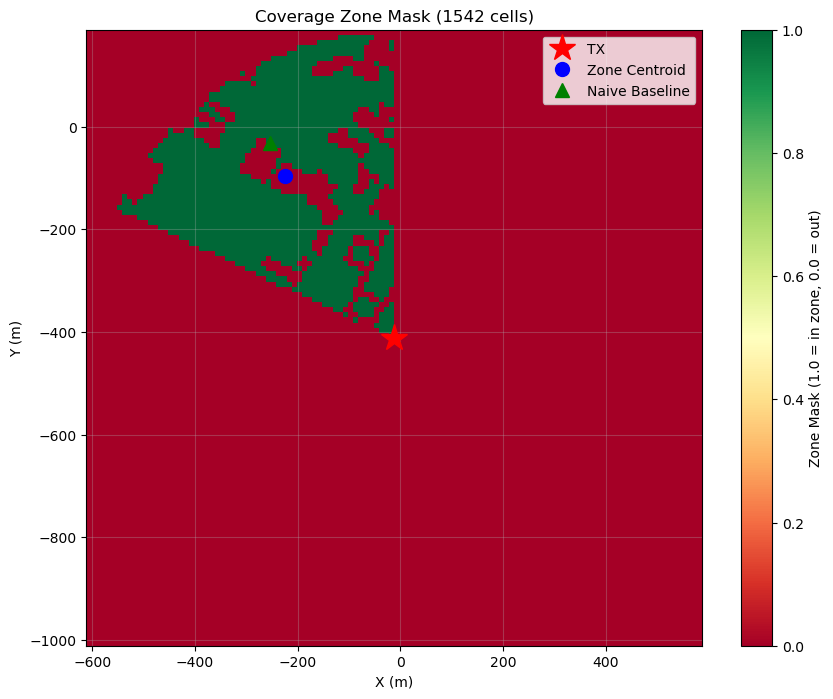

STARTING BINARY MASK OPTIMIZATION

Binary Mask Zone Coverage Optimization
Use grid search init: True
Learning rate: 0.15
Iterations: 100
Sample points: 600
Loss type: coverage_threshold
Power threshold: -80.0 dB
Map config: {'center': [-11.582345008850098, -411.2144775390625, 0], 'size': [1200, 1200], 'cell_size': (10, 10), 'ground_height': 0.0}


PHASE 1: Grid Search for Initial Boresight


Grid Search for Initial Boresight
TX position: (-11.6, -411.2, 19.0)
Angular samples: 20
Elevation samples: 10
Total directions to test: 200

[1/200] NEW BEST: Az=0°, El=0° → -175.5 dB
[2/200] NEW BEST: Az=0°, El=-5° → -175.5 dB
[5/200] Az=0°, El=-20° → -175.6 dB
[10/200] Az=0°, El=-45° → -176.7 dB
[11/200] NEW BEST: Az=18°, El=0° → -175.4 dB
[13/200] NEW BEST: Az=18°, El=-10° → -175.3 dB
[15/200] Az=18°, El=-20° → -175.7 dB
[20/200] Az=18°, El=-45° → -176.8 dB
[21/200] NEW BEST: Az=36°, El=0° → -175.0 dB
[22/200] NEW BEST: Az=36°, El=-5° → -174.8 dB
[25/200] Az=36°, El=-20° → -175.0 dB
[30/200] Az

In [ ]:
from boresight_pathsolver import (
    optimize_boresight_pathsolver,
    create_zone_mask
)
import matplotlib.pyplot as plt

# ============================================
# NEW BINARY MASK APPROACH
# ============================================
# Instead of creating a target radiomap with specific power levels,
# we create a BINARY MASK that defines the coverage zone.
# The optimizer will maximize coverage within this zone.

# Map configuration
map_config = {
    'center': [gnb_position[0], gnb_position[1], 0],
    'size': [1200, 1200],
    'cell_size': (5, 5),
    'ground_height': 0.0,
}

# ============================================
# OPTION 1: Angular Sector Zone (RECOMMENDED)
# ============================================
# Create a wedge-shaped sector pointing from the TX
zone_mask, naive_look_at, zone_stats = create_zone_mask(
    map_config=map_config,
    zone_type='angular_sector',
    origin_point=gnb_position,
    zone_params={
        'angle_start': 90,
        'angle_end': 90+65,      # Try 65° to match TR38.901 beamwidth
        'radius': 600         # Larger radius
    },
    target_height=0.0,
    scene_xml_path="/home/tingjunlab/Development/geo2sigmap/scenes/Duke/scene.xml",
    exclude_buildings=True           # ← This is True by default
)

print("=" * 70)
print("ZONE MASK CREATED")
print("=" * 70)
print(f"Zone type: Angular sector (0° to 120°, radius 100m)")
print(f"Zone contains {zone_stats['num_cells']} grid cells")
print(f"Zone coverage: {zone_stats['coverage_fraction']*100:.1f}% of map")
print(f"Naive baseline look-at: {zone_stats['look_at_xyz']}")
print(f"Zone centroid: {zone_stats['centroid_xy']}")
print()

# Visualize the Zone Mask
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    zone_mask,
    origin='lower',
    cmap='RdYlGn',
    extent=[
        map_config['center'][0] - map_config['size'][0]/2,
        map_config['center'][0] + map_config['size'][0]/2,
        map_config['center'][1] - map_config['size'][1]/2,
        map_config['center'][1] + map_config['size'][1]/2,
    ],
    vmin=0,
    vmax=1
)
plt.colorbar(im, ax=ax, label='Zone Mask (1.0 = in zone, 0.0 = out)')
ax.plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
ax.plot(zone_stats['centroid_xy'][0], zone_stats['centroid_xy'][1], 'bo',
        markersize=10, label='Zone Centroid')
ax.plot(zone_stats['look_at_xyz'][0], zone_stats['look_at_xyz'][1], 'g^',
        markersize=10, label='Naive Baseline')
ax.set_title(f'Coverage Zone Mask ({zone_stats["num_cells"]} cells)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# ============================================
# Run Optimization with Binary Mask
# ============================================
print("=" * 70)
print("STARTING BINARY MASK OPTIMIZATION")
print("=" * 70)

# NEW: Returns angles [azimuth, elevation] instead of Cartesian coordinates
best_angles, loss_hist, angle_hist, grad_hist, cov_stats = optimize_boresight_pathsolver(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    scene_xml_path=scene_xml_path,
    zone_mask=zone_mask,
    initial_boresight=naive_look_at.tolist(),  # Converted to angles internally
    num_sample_points=800,
    learning_rate=.15,
    num_iterations=100,
    loss_type='coverage_threshold',
    use_grid_search_init=True,
    grid_search_params={
        'num_angular_samples': 20,  # Finer grid = better init
        'num_elevation_samples': 10,  # More elevation angles
        'num_sample_points': 50,   # Fast grid search
    },
    power_threshold_dbm=-80,
    verbose=True,
    seed=22,
    save_radiomap_frames=False,
    frame_save_interval=10,
    output_dir="/home/tingjunlab/Development/optimize_tx/optimization_gif"
)

print(f"\nOptimization complete!")
print(f"Best angles: Azimuth={best_angles[0]:.1f}°, Elevation={best_angles[1]:.1f}°")
print(f"Final coverage stats: {cov_stats}")

[-11.582345008850098, -411.2144775390625, 19.0]
Naive baseline angles: Azimuth=122.5°, Elevation=-2.4°
Optimized angles: Azimuth=195.0°, Elevation=-2.6°

Computing RadioMap for Naive Baseline...
  Angles: Azimuth=122.5°, Elevation=-2.4°
Computing RadioMap for Optimized...
  Angles: Azimuth=195.0°, Elevation=-2.6°

COMPARISON SUMMARY
Naive Baseline Mean:  -84.47 dBm
Optimized Mean:       -75.56 dBm
Improvement:          +8.91 dBm (10.5%)



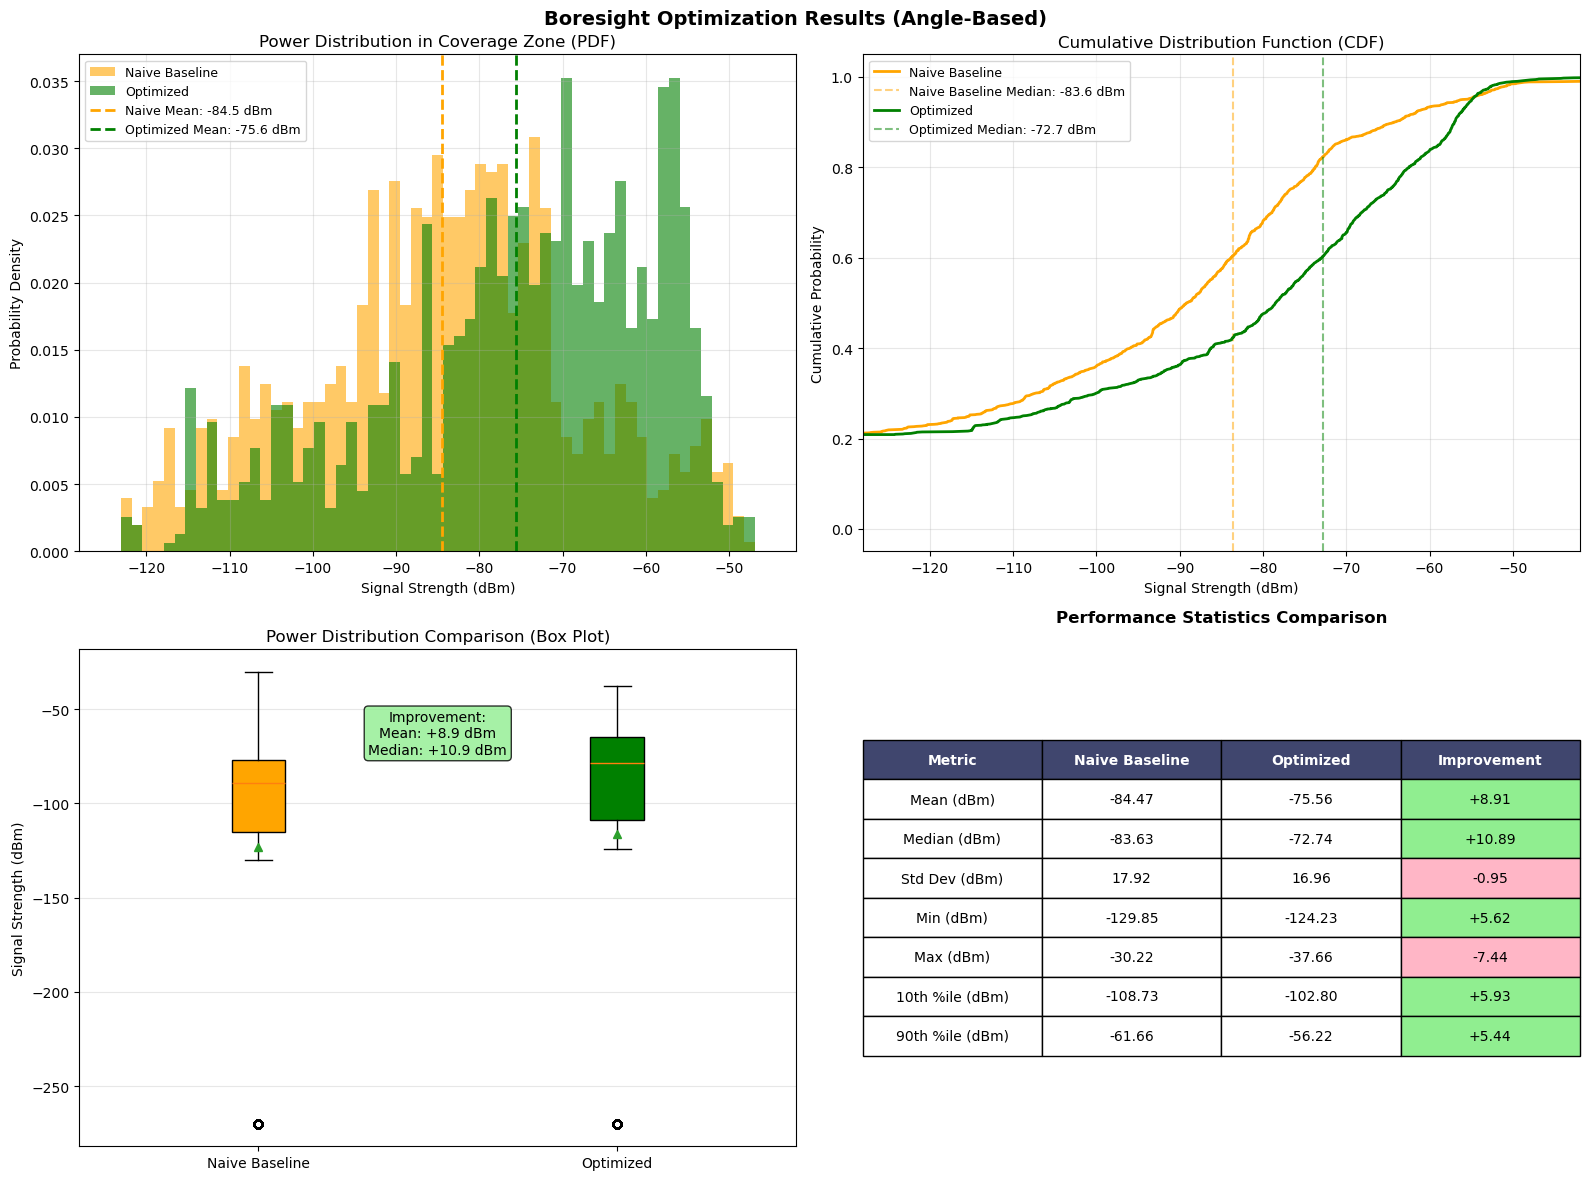


Mean improvement: 8.91 dB
Median improvement: 10.89 dB
Percentage improvement: 10.5%


In [8]:
from boresight_pathsolver import compare_boresight_performance
from angle_utils import azimuth_elevation_to_yaw_pitch, compute_initial_angles_from_position
import mitsuba as mi

# Compute naive angles from the naive look_at position
tx = scene.get("gnb")
tx_position = [
    float(tx.position[0][0]),
    float(tx.position[1][0]),
    float(tx.position[2][0])
]
print(tx_position)

# Convert naive look_at position to angles
naive_azimuth, naive_elevation = compute_initial_angles_from_position(
    tx_position, naive_look_at.tolist()
)
naive_angles = [naive_azimuth, naive_elevation]

print(f"Naive baseline angles: Azimuth={naive_azimuth:.1f}°, Elevation={naive_elevation:.1f}°")
print(f"Optimized angles: Azimuth={best_angles[0]:.1f}°, Elevation={best_angles[1]:.1f}°")
print()

# Compare performance using angles
fig, comparison_stats = compare_boresight_performance(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    zone_mask=zone_mask,
    naive_angles=naive_angles,
    optimized_angles=best_angles,
    title="Boresight Optimization Results (Angle-Based)"
)

plt.show()

# Print detailed stats
print(f"\nMean improvement: {comparison_stats['improvement_mean_dBm']:.2f} dB")
print(f"Median improvement: {comparison_stats['improvement_median_dBm']:.2f} dB")
print(f"Percentage improvement: {comparison_stats['improvement_percent']:.1f}%")

RADIO MAP VISUALIZATION (OPTIMIZED)
Optimized angles: Azimuth=195.0°, Elevation=-2.6°
TX location: [[-11.5823, -411.214, 19]]
TX orientation (yaw, pitch, roll): (3.404, 0.046, 0.0) rad
Coverage zone: 600/600 samples
Final loss: 10.5913

Coverage Analysis:
  Mean power in zone: -95.09 dBm
  Median power in zone: -77.67 dBm
  Min power in zone: -270.00 dBm
  Max power in zone: -37.27 dBm
  Std dev in zone: 56.17 dB

  Above -90 dBm: 1020/1542 (66.1%)
  Above -85 dBm: 941/1542 (61.0%)
  Above -80 dBm: 841/1542 (54.5%)
  Above -75 dBm: 690/1542 (44.7%)
  Above -70 dBm: 537/1542 (34.8%)



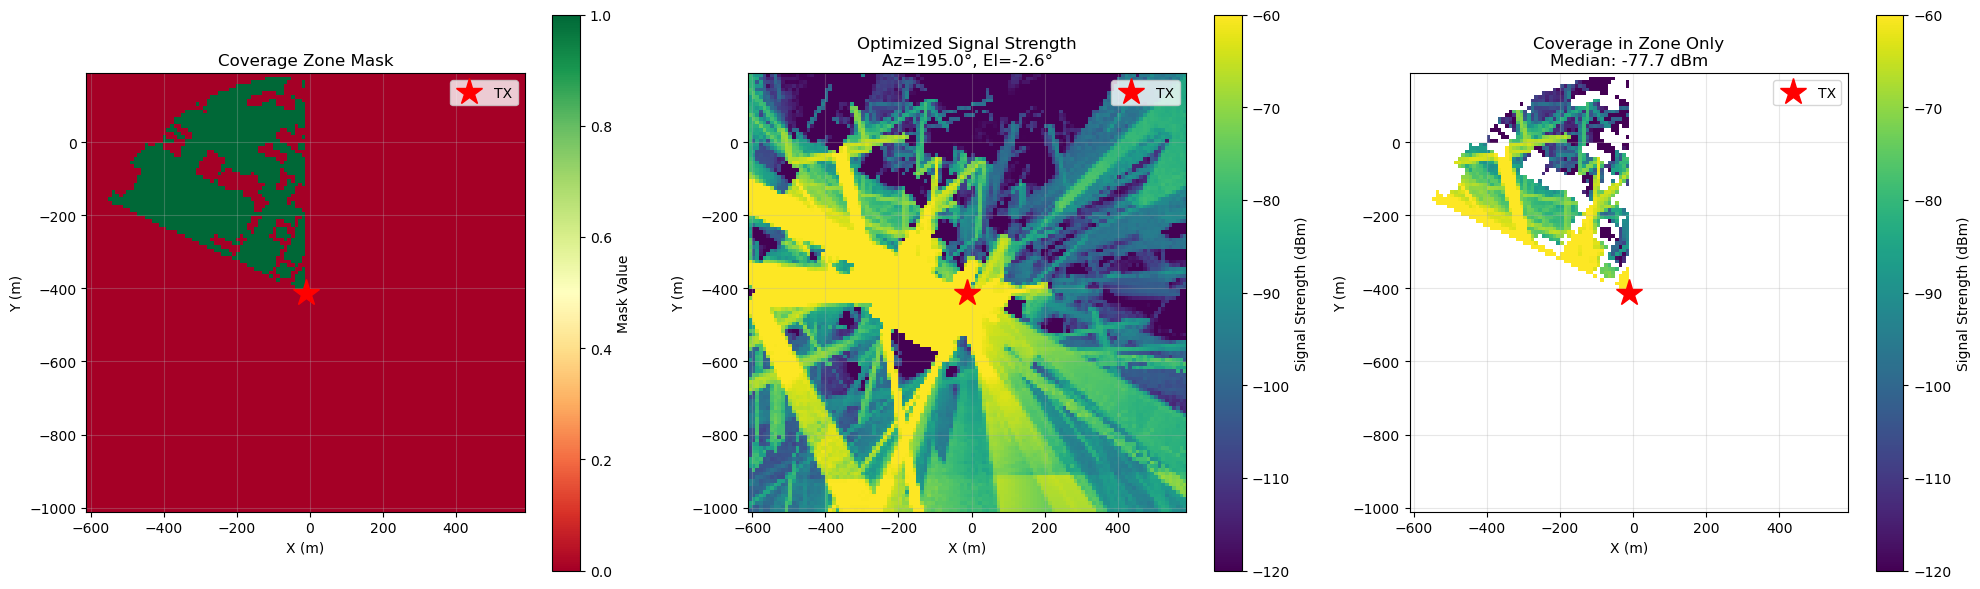

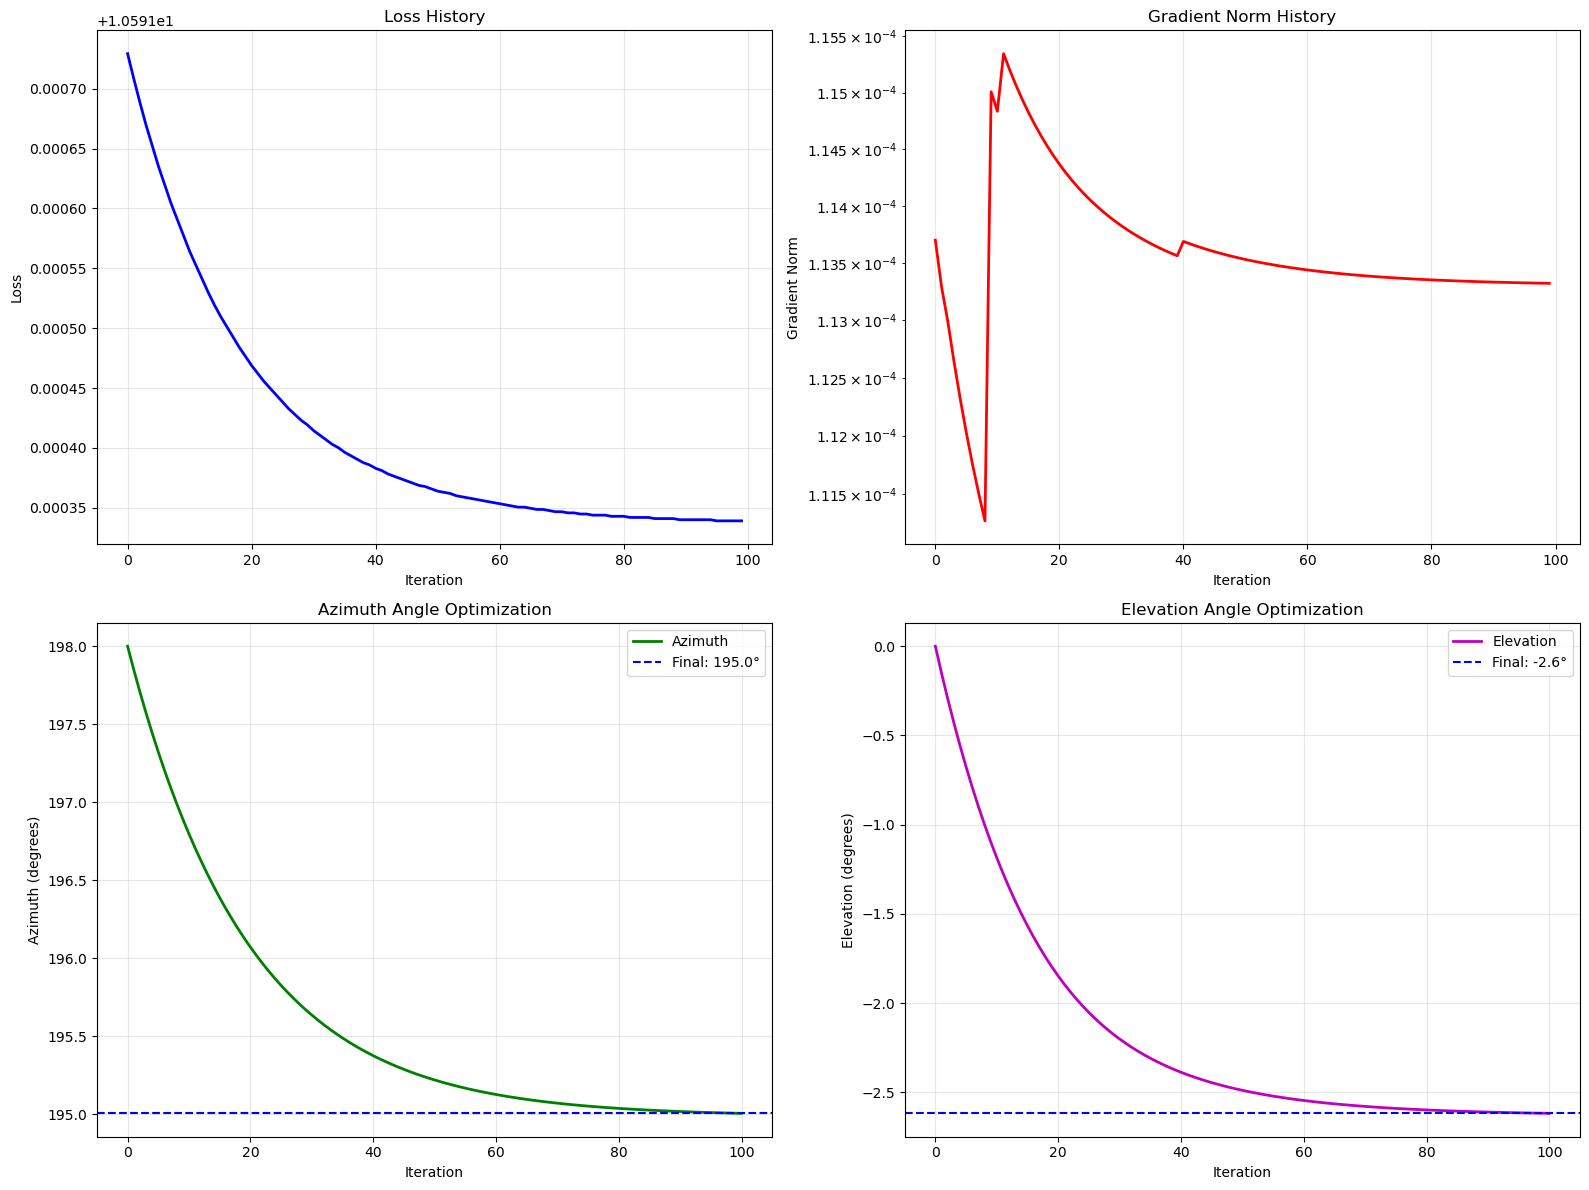

In [9]:
from sionna.rt import RadioMapSolver
from angle_utils import azimuth_elevation_to_yaw_pitch
import matplotlib.pyplot as plt
import mitsuba as mi

# Apply the optimized angles to the transmitter
tx = scene.get("gnb")
best_azimuth, best_elevation = best_angles
yaw_rad, pitch_rad = azimuth_elevation_to_yaw_pitch(best_azimuth, best_elevation)
tx.orientation = mi.Point3f(float(yaw_rad), float(pitch_rad), 0.0)

print("=" * 70)
print("RADIO MAP VISUALIZATION (OPTIMIZED)")
print("=" * 70)
print(f"Optimized angles: Azimuth={best_azimuth:.1f}°, Elevation={best_elevation:.1f}°")
print(f"TX location: {tx.position}")
print(f"TX orientation (yaw, pitch, roll): ({yaw_rad:.3f}, {pitch_rad:.3f}, 0.0) rad")
print(f"Coverage zone: {cov_stats['num_samples_in_zone']}/{cov_stats['num_samples_total']} samples")
print(f"Final loss: {cov_stats['final_loss']:.4f}")
print()

# Generate radio map matching the optimization configuration
rm_solver = RadioMapSolver()
rm = rm_solver(
    scene,
    max_depth=5,
    samples_per_tx=int(6e8),
    cell_size=map_config['cell_size'],
    center=map_config['center'],
    orientation=[0, 0, 0],
    size=map_config['size'],
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    diffraction=True,
    edge_diffraction=True,
    refraction=False,
    stop_threshold=None,
)

# Extract signal levels
rss_watts = rm.rss.numpy()[0, :, :]
signal_strength_dBm = 10.0 * np.log10(rss_watts + 1e-30) + 30.0

# ============================================
# Analyze Coverage in the Zone
# ============================================
zone_power = signal_strength_dBm[zone_mask == 1.0]

print("Coverage Analysis:")
print(f"  Mean power in zone: {np.mean(zone_power):.2f} dBm")
print(f"  Median power in zone: {np.median(zone_power):.2f} dBm")
print(f"  Min power in zone: {np.min(zone_power):.2f} dBm")
print(f"  Max power in zone: {np.max(zone_power):.2f} dBm")
print(f"  Std dev in zone: {np.std(zone_power):.2f} dB")
print()

# Count cells above various thresholds
thresholds = [-90, -85, -80, -75, -70]
for thresh in thresholds:
    above = np.sum(zone_power > thresh)
    pct = 100.0 * above / len(zone_power)
    print(f"  Above {thresh} dBm: {above}/{len(zone_power)} ({pct:.1f}%)")
print()

# ============================================
# Visualize Results
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

extent = [
    map_config['center'][0] - map_config['size'][0]/2,
    map_config['center'][0] + map_config['size'][0]/2,
    map_config['center'][1] - map_config['size'][1]/2,
    map_config['center'][1] + map_config['size'][1]/2,
]

# Plot 1: Zone Mask
im1 = axes[0].imshow(zone_mask, origin='lower', cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
axes[0].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[0].set_title('Coverage Zone Mask')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0], label='Mask Value')

# Plot 2: RadioMap (Signal Strength)
im2 = axes[1].imshow(signal_strength_dBm, origin='lower', cmap='viridis', 
                     extent=extent, vmin=-120, vmax=-60)
axes[1].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[1].set_title(f'Optimized Signal Strength\nAz={best_azimuth:.1f}°, El={best_elevation:.1f}°')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[1], label='Signal Strength (dBm)')

# Plot 3: Masked Coverage (only show zone)
masked_signal = np.where(zone_mask == 1.0, signal_strength_dBm, np.nan)
im3 = axes[2].imshow(masked_signal, origin='lower', cmap='viridis',
                     extent=extent, vmin=-120, vmax=-60)
axes[2].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[2].set_title(f'Coverage in Zone Only\nMedian: {np.median(zone_power):.1f} dBm')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.colorbar(im3, ax=axes[2], label='Signal Strength (dBm)')

plt.tight_layout()
plt.show()

# ============================================
# Optimization Diagnostics - UPDATED for Angles
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss history
axes[0, 0].plot(loss_hist, 'b-', linewidth=2)
axes[0, 0].set_title('Loss History')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Gradient norms
axes[0, 1].plot(grad_hist, 'r-', linewidth=2)
axes[0, 1].set_title('Gradient Norm History')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Gradient Norm')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Angle trajectory - Azimuth
angle_arr = np.array(angle_hist)
axes[1, 0].plot(angle_arr[:, 0], 'g-', linewidth=2, label='Azimuth')
axes[1, 0].axhline(y=best_azimuth, color='b', linestyle='--', label=f'Final: {best_azimuth:.1f}°')
axes[1, 0].set_title('Azimuth Angle Optimization')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Azimuth (degrees)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Angle trajectory - Elevation
axes[1, 1].plot(angle_arr[:, 1], 'm-', linewidth=2, label='Elevation')
axes[1, 1].axhline(y=best_elevation, color='b', linestyle='--', label=f'Final: {best_elevation:.1f}°')
axes[1, 1].set_title('Elevation Angle Optimization')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Elevation (degrees)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scene preview with optimized radiomap
scene.preview(radio_map=rm)